# Logistic Regression Classification
Logistic Regression is a classification technique that aims to squash the Linear Regression model into the interval [0,1] so that it can be used as a binary classifier.  The resulting score gives an estimate of the probability of an observation belonging to the positive class in a binary classification situation.

In this exercise, we'll try out logistic regression against 2 datasets: one for predicting graduate school admission and the other for predicting flight delays.  We'll see how to perform logistic regression with multiple python packages and interpret the subsequent logistic regression results in a probabilistic context. 

## Learning Goals
- Perform Logistic Regression with `statsmodels`
- Perform Logistic Regression with `sklearn`
- Interpret the results of logistic regression
- Handle categorical input (predictor) variables by transforming to dummy variables in `pandas`

## Datasets
- [Graduate School Admissions](http://www.ats.ucla.edu/stat/data/binary.csv)
- [Flight Delays](https://catalog.data.gov/dataset/airline-on-time-performance-and-causes-of-flight-delays)

## Graduate School Admission
We'll be using the same dataset as [UCLA's Logit Regression in R tutorial](http://www.ats.ucla.edu/stat/r/dae/logit.htm) to explore logistic regression in Python. Our goal will be to identify the various factors that may influence admission into graduate school.

The dataset contains several columns which we can use as predictor variables:

- gpa
- gre score
- rank or prestige of an applicant's undergraduate alma mater

The fourth column, admit, is our binary target variable. It indicates whether or not a candidate was admitted our not.

### Load in the Data
Let's use `pandas.read_csv()` to read the dataset into a `DataFrame` for exploration.

In [257]:
#Imports
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import seaborn as sns
import numpy as np
%matplotlib inline

# read the data in from http://www.ats.ucla.edu/stat/data/binary.csv
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
# take a look at the dataset with head()
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### Explore the Data
Since there is also a `DataFrame` function called `rank()`, let's change the name of the "rank" column to "prestige".

In [258]:
# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.columns = [u'admit', u'gre', u'gpa', u'prestige']
df.head()

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Let'explore the data:

In [259]:
# summarize the data with describe()
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [260]:
# take a look at the standard deviation of each column with std()
df.std()

admit         0.466087
gre         115.516536
gpa           0.380567
prestige      0.944460
dtype: float64

A nice `pandas` function is the [`crosstab()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html) function which allows you to slice across different variables and display frequencies or other aggregations (akin to a [Pivot Table](https://en.wikipedia.org/wiki/Pivot_table) in Excel).  Let's use it to take a look at how the counts of admitted and not admitted look as a function of prestige:

In [261]:
# frequency table cutting prestige and whether or not someone was admitted
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


We can get a visual look at this with a bar chart:

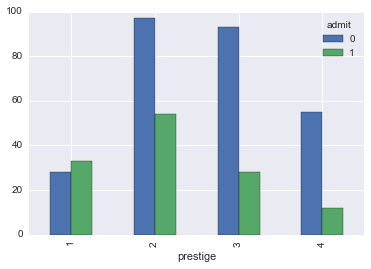

In [262]:
x = pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])
x.transpose().plot(kind='bar')

Notice that the proportion of admits is higher for the more prestigious undergraduate schools.  As an exercise, try to generate a similar table showing the admits by **gre** score.  First bucket gre score into 7 buckets (200-300, 300-400, 400-500, 500-600, 600-700, 700-800, 800).  

**HINT**: Divid the gre column by 100 first, then call a `map()` function on the resulting series where the map makes a call to `math.floor()` (you'll need to import `math` first).

In [263]:
import math



# pd.crosstab(df['admit'], (df['gre']/100).map(lambda x: math.floor(x))), rownames=['admit'])

Do you notice a relationship between gre score and admission here?  Is it what you'd expect?

Now let's use the `pandas.DataFrame.hist()` function to generate histograms for each of the 4 variables to get a quick feel for how they're distributed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11088f310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111713a10>]], dtype=object)

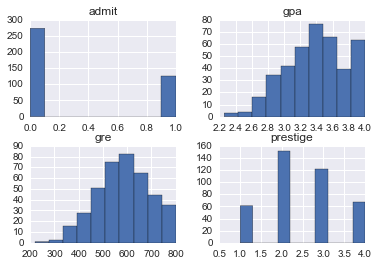

In [264]:
# plot all of the columns with hist()
df.hist()

#### Dummy Variables
`pandas` gives you a great deal of control over how categorical variables are represented. We're going dummify the **prestige** column using [`get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

`get_dummies()` creates a new DataFrame with binary indicator variables for each category/option in the column specified. In this case, prestige has four levels: 1, 2, 3 and 4 (1 being most prestigious). When we call `get_dummies()`, we get a dataframe with four columns, each of which describes one of those levels.

Create a new temporary dataframe by calling `get_dummies()` on the prestige column with the  prefix "prestige" to create dummy variables for each of the 4 prestige values.

In [265]:
# dummify prestige
dummy_prestige = pd.get_dummies(df["prestige"], prefix="prestige")
# Take a look at your dummified frame with head()
dummy_prestige.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [266]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_prestige.ix[:, 'prestige_2':])
print data.head()

# manually add the intercept
data['intercept'] = 1.0

   admit  gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380  3.61           0           1           0
1      1  660  3.67           0           1           0
2      1  800  4.00           0           0           0
3      1  640  3.19           0           0           1
4      0  520  2.93           0           0           1


Once that's done, we merge the new dummy columns into the original dataset and get rid of the prestige column which we no longer need.  We're going to treat **prestige_1** as our baseline and exclude it from our fit. This is done to prevent [**multicollinearity**](https://en.wikipedia.org/wiki/Multicollinearity), or the [**dummy variable trap**](https://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29#Precautions_in_the_usage_of_dummy_variables) caused by including a dummy variable for every single category.

Lastly we're going to add a constant term for our Logistic Regression. The `statsmodels` function we're going to be using requires that intercepts/constants are specified explicitly.

### Perform the Regression
As we did with Linear Regression, first we'll try out the Logistic Regression with `statsmodels`, before showing how we can accomplish the corresponding task with `sklearn`.

#### Logistic Regression with `statsmodels`
For `statsmodels` we must call `sm.Logit(y, X)` with the target variable **admit** as `y` and the predictor columns as `X`.  We can then call `fit()` to fit our model.  Here's how we might do that:

In [267]:
# Select out all of our desired predictors (not admit and prestige_1)
train_cols = data.columns[1:]
print train_cols
# Create our model
logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
result = logit.fit()
data.head()

Index([u'gre', u'gpa', u'prestige_2', u'prestige_3', u'prestige_4',
       u'intercept'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1
1,1,660,3.67,0,1,0,1
2,1,800,4.00,0,0,0,1
3,1,640,3.19,0,0,1,1
4,0,520,2.93,0,0,1,1


##### Interpreting `statsmodels` Results
Now that we've fit a model, we can print out some nice summary results as we did before with Linear Regression:

In [268]:
# Summarize statsmodels results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Nov 2015   Pseudo R-squ.:                 0.08292
Time:                        23:01:00   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038         0.000     0.004
gpa            0.8040      0.332      2.423      0.015         0.154     1.454
prestige_2    -0.6754      0.316     -2.134      0.033        -1.296    -0.055
prestige_3    -1.3402      0.345     -3.881      0.000        -2.017    -0.663
prestige_4    -1.5515      0.418     -3.713      0.000        -2.370    -0.733
intercept     -3.9900      1.140     -3.500      0.000        -6.224    -1.756
==============================================================================
"""

In this example, we're very confident that there is an inverse relationship between the probability of being admitted and the prestige of a candidate's undergraduate school.  We know this because all of their coefficients are (increasingly) negative with very low P values.

In other words, the probability of being accepted into a graduate program is higher for students who attended a top ranked undergraduate college (prestige_1==True) as opposed to a lower ranked school with, say, prestige_4==True (remember, a prestige of 1 is the most prestigious and a prestige of 4 is the least prestigious.

##### Odds Ratio
Take the exponential of each of the coefficients to generate the odds ratios. This tells you how a 1 unit increase or decrease in a variable affects the odds of being admitted. For example, we can expect the odds of being admitted to decrease by about 50% if the prestige of a school is 2. UCLA gives a more in depth explanation of the odds ratio [here](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm).

In [269]:
# print odds ratios only
print np.exp(result.params)

gre           1.002267
gpa           2.234545
prestige_2    0.508931
prestige_3    0.261792
prestige_4    0.211938
intercept     0.018500
dtype: float64


We can also do the same calculations using the coefficients estimated using the confidence interval to get a better picture for how uncertainty in variables can impact the admission rate.

In [270]:
# odds ratios and 95% CI
params = result.params
# Get confidence intervals
conf = result.conf_int()
# Append the Odds Ratios
conf['OR'] = params
# Print out the odds ratio 95% confidence intervals
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                2.5%     97.5%        OR
gre         1.000120  1.004418  1.002267
gpa         1.166122  4.281877  2.234545
prestige_2  0.273692  0.946358  0.508931
prestige_3  0.133055  0.515089  0.261792
prestige_4  0.093443  0.480692  0.211938
intercept   0.001981  0.172783  0.018500


##### Going Further
As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called `cartesian()` which I originally found [here](http://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays).

The other new function we're going to use is `np.linspace()` to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [271]:
# Define cartesian helper function
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [272]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres

gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas

# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_prestige = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_prestige.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_prestige.ix[:, 'prestige_2':])

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])

combos.head()

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


/Users/keith/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/keith/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4,admit_pred
0,220,2.260000,1,1,0,0,0,0.157801
1,220,2.260000,2,1,1,0,0,0.087056
2,220,2.260000,3,1,0,1,0,0.046758
3,220,2.260000,4,1,0,0,1,0.038194
4,220,2.453333,1,1,0,0,0,0.179574


Now that we've generated our predictions, let's make some plots to visualize the results. I created a small helper function called `isolate_and_plot()` which allows you to compare a given variable with the different prestige levels and the mean probability for that combination. To isolate prestige and the other variable I used a pivot_table which allows you to easily aggregate the data.

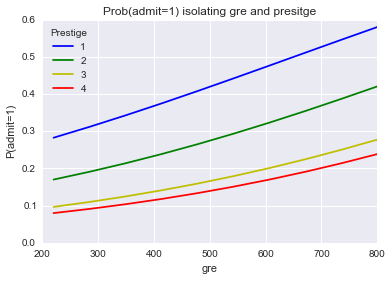

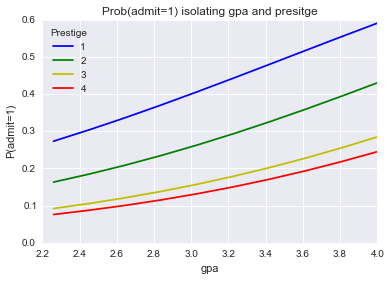

In [273]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
    # in case you're curious as to what this looks like
    # print grouped.head()
    #                      admit_pred
    # gre        prestige            
    # 220.000000 1           0.282462
    #            2           0.169987
    #            3           0.096544
    #            4           0.079859
    # 284.444444 1           0.311718
    
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')

The resulting plots shows how gre, gpa, and prestige affect the admission levels. You can see how the probability of admission gradually increases as gre and gpa increase and that the different prestige levels yield drastic probabilities of admission (particularly the most/least prestigious schools).

#### Logistic Regression with `sklearn`
Use the `sklearn.linear_model.LogisticRegression` class with a 70/30 train/test split to build and evaluate a model based on the dummified prestige (2, 3, 4) and the gre and gpa fields.  Score your model, how does it perform?  What other metrics can you examine?  What other ways could you cross-validate (hint: try #### Logistic Regression with `sklearn`
)?

In [274]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data[['gre','gpa','prestige_2','prestige_3','prestige_4']], data["admit"], test_size=0.3)
lr = LogisticRegressionCV()
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [275]:
lr.score(X_test, y_test)

0.64166666666666672

In [276]:
print data['admit'].value_counts()
print "acceptance rate: %",127.0/400.0

0    273
1    127
Name: admit, dtype: int64
acceptance rate: % 0.3175


## Flight Delay Prediction
Our 2nd dataset for Logistic Regression practice will have us trying to predict which flights are going to be delayed.

### Get the Data
Download the [data](https://github.com/pburkard88/DS_BOS_06/blob/master/Data/Flight_Delays/FlightDelays.csv), load it in using `pandas.read_csv()` and inspect it with `head()`:

In [277]:
# Load in the data
fd = pd.read_csv("~/repos/personal/DS_BOS_07/Data/Flight_Delays/FlightDelays.csv")
# Inspect with head
fd.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,1/1/04,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,1/1/04,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,1/1/04,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,1/1/04,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,1/1/04,7792,IAD,0,4,1,N698BR,ontime


### Explore the Data
The next step in predictive analytics is to explore our underlying data. Let’s do a few plots of our explantory variables to see how they look against Delayed Flights.

Generate a histogram of the flight statuses.  Do this by calling `value_counts()` on the **Flight Status** column and then calling `plot()` with `kind='bar'`:

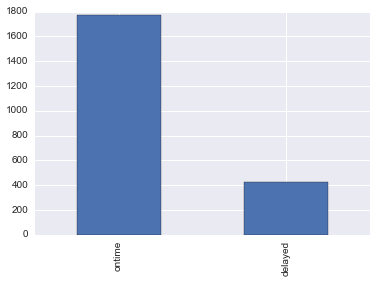

In [278]:
fd["Flight Status"].value_counts().plot(kind='bar')

Use the `value_counts()` function along with `shape` to return the percentage of records represented by each carrier

In [279]:
# Percentage of records by each carrier
from __future__ import division
fd["CARRIER"].value_counts().map(lambda x: x/fd.shape[0])



DH    0.250341
RU    0.185370
US    0.183553
DL    0.176284
MQ    0.134030
CO    0.042708
UA    0.014085
OH    0.013630
Name: CARRIER, dtype: float64

Please note the following on carriers:  
CO: Continental  
DH: Atlantic Coast  
DL: Delta  
MQ: American Eagle  
OH: Comair  
RU: Continental Express  
UA: United  
US: US Airways  

Try creating a `crosstab` and subsequent bar plot the same way we did above, this time with Flight Status and Day of the Week.

In [280]:
cross = pd.crosstab(fd['Flight Status'], fd['CARRIER'], rownames=['Flight Status'])
cross

CARRIER,CO,DH,DL,MQ,OH,RU,UA,US
Flight Status,,,,,,,,
delayed,26,137,47,80,4,94,5,35
ontime,68,414,341,215,26,314,26,369


Do you notice anything in particular?  Is there a way we could make this visualization more useful?

Try the same thing for the Destination and Origin variables:

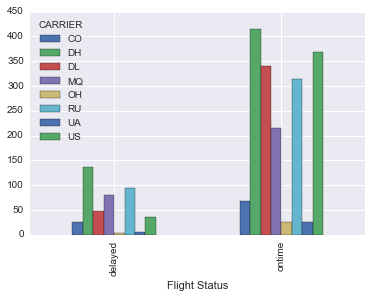

In [281]:
cross.plot(kind='bar')

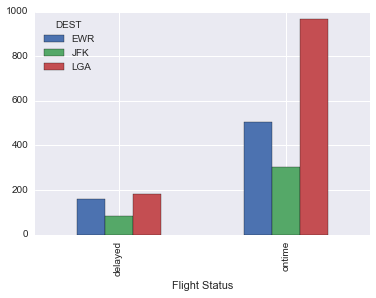

In [282]:
cross_dest = pd.crosstab(fd['Flight Status'], fd['DEST'], rownames=['Flight Status'])
cross_dest.plot(kind='bar')

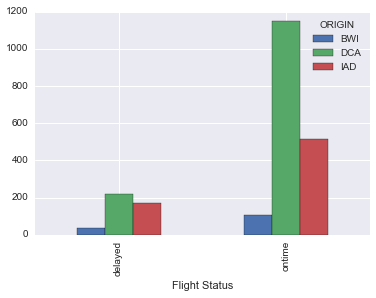

In [283]:
cross_org = pd.crosstab(fd['Flight Status'], fd['ORIGIN'], rownames=['Flight Status'])
cross_org.plot(kind='bar')

### Data Preprocessing
This first transformation we’ll need to do is to convert the categorical variables into dummy variables.
The four categorical variables of interests are: 1) Carrier 2) Destination (airport codes) 3) Origin (airport codes) 4) Day of the Week. For simplicity of model building, we’ll NOT use Day of the Month, because of the combinatorial explosion in number of dummy variables. The reader is free to do this as an exercise on his/her own. :)

Use `pandas.get_dummies()` on those 4 categorical variables to create dummy variables for them and store them in a temporary dataframe `df_dummies`.  Generate a new dataframe `df` that contains only the numeric variables and dummified variables.

In [284]:
### Get the weekday dummies
wk_dummies = pd.get_dummies(fd["DAY_WEEK"], prefix="day_of_week")

# Set the weekday dummy column names to something bette
day_names = {"day_of_week_1": "Monday","day_of_week_2": "Tuesday","day_of_week_3": "Wednesday","day_of_week_4": "Thursday","day_of_week_5": "Friday","day_of_week_6": "Saturday","day_of_week_7": "Sunday"}
dummies = wk_dummies.rename(columns =day_names)
dummies.head()
# Get the Carrier, Destination, and Origin dummies
carries_dummies = pd.get_dummies(fd[["CARRIER", "DEST", "ORIGIN"]], prefix=["Carrier","Dest", "orgin"])
carries_dummies.head()

# Join the 2 dummies frames
res = pd.concat([carries_dummies,wk_dummies,fd[["CRS_DEP_TIME","DEP_TIME","DISTANCE","FL_NUM","Weather",'Flight Status']]], axis=1, join_axes=[carries_dummies.index])

# convert flight_status to 
res['Flight Status'] = res['Flight Status'].map(lambda x: 0 if x == "ontime" else 1)
# Display the results

res.head()

,Carrier_CO,Carrier_DH,Carrier_DL,Carrier_MQ,Carrier_OH,Carrier_RU,Carrier_UA,Carrier_US,Dest_EWR,Dest_JFK,...,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,Weather,Flight Status
0,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,1455,1455,184,5935,0,0
1,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,1640,1640,213,6155,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1245,1245,229,7208,0,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1715,1709,229,7215,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1039,1035,229,7792,0,0


### Fitting Our Model
Try fitting a model to our data using `sklearn`.  For now, just use the variables that we created as dummy variable predictors, and the **Flight Status** variable as our output variable.  You can use either the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class with an explicit 70/30 train/test split or [`LogisticRegressionCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) with k-fold cross-validation.

In [285]:
# Imports
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split

%matplotlib inline

# Train/test split
X_fdtrain, X_fdtest, y_fdtrain, y_fdtest = train_test_split(res[['CRS_DEP_TIME', 'Carrier_CO', 'Carrier_DH', 'Carrier_DL',
       'Carrier_MQ', 'Carrier_OH', 'Carrier_RU', 'Carrier_UA',
       'Carrier_US', 'DEP_TIME', 'DISTANCE', 'Dest_EWR', 'Dest_JFK',
       'Dest_LGA', 'FL_NUM', 'Weather', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'day_of_week_7', 'orgin_BWI', 'orgin_DCA',
       'orgin_IAD']], res["Flight Status"], test_size=0.3)

# Create Model
lr = LogisticRegressionCV()

# Fit model
lr.fit(X_fdtrain, y_fdtrain)
# Score model
lr.score(X_fdtest, y_fdtest)


0.913767019667171

### Interpreting Our Results
Print out the coefficients of your resulting model with a call to `coef`:

In [286]:
coefs = lr.coef_
print coefs

[[ -3.44488342e-02   1.90590537e-01  -1.59785797e-01  -6.78331372e-01
    5.57190538e-01  -1.99602985e-01   2.90608637e-02  -5.38506763e-02
    2.69203089e-01   3.48429368e-02  -9.92269478e-03   1.10653169e-01
   -2.64213567e-01   1.08034595e-01  -3.39270706e-05   4.93494886e-01
    2.64289378e-01  -4.86030082e-03   1.20338579e-01  -2.21033588e-01
    2.00654358e-02  -3.59048604e-01   1.34723297e-01  -3.07360118e-01
    1.02704275e-01   1.59130040e-01]]


Use `np.exp()` to determine the Odds Ratios for your model:

In [287]:
np.exp(coefs)

array([[ 0.96613777,  1.20996391,  0.85232634,  0.50746305,  1.74576095,
         0.81905587,  1.02948725,  0.94757359,  1.30892094,  1.03545706,
         0.99012637,  1.11700743,  0.76780954,  1.11408629,  0.99996607,
         1.63803096,  1.30250506,  0.99515149,  1.12787866,  0.80168975,
         1.0202681 ,  0.69834041,  1.14422013,  0.73538573,  1.10816365,
         1.17249041]])

Use the `zip()` and `sorted()` functions to generate a sorted list of the odds ratios alongside the respective table column names.

In [288]:
coeflist = np.exp(coefs).tolist()[0]
cols = res.columns.tolist()

zipped = zip(cols, coeflist )
sorted(zipped,key=lambda pair: pair[1])

[('Carrier_MQ', 0.507463053508645),
 ('CRS_DEP_TIME', 0.6983404081624202),
 ('DISTANCE', 0.7353857277077304),
 ('orgin_DCA', 0.767809543138788),
 ('day_of_week_6', 0.8016897528467253),
 ('Carrier_RU', 0.8190558656306581),
 ('Carrier_DL', 0.852326340014541),
 ('Carrier_US', 0.9475735910884111),
 ('Carrier_CO', 0.9661377716543128),
 ('Dest_LGA', 0.9901263727290508),
 ('day_of_week_4', 0.9951514913297267),
 ('day_of_week_1', 0.9999660735048855),
 ('day_of_week_7', 1.020268099943235),
 ('Carrier_UA', 1.0294872510089867),
 ('Dest_JFK', 1.0354570637774732),
 ('FL_NUM', 1.1081636489946984),
 ('orgin_IAD', 1.1140862863402436),
 ('orgin_BWI', 1.117007427304662),
 ('day_of_week_5', 1.127878663261627),
 ('DEP_TIME', 1.1442201313668219),
 ('Weather', 1.1724904070556177),
 ('Carrier_DH', 1.2099639149941963),
 ('day_of_week_3', 1.302505057818588),
 ('Dest_EWR', 1.308920942137333),
 ('day_of_week_2', 1.6380309592747648),
 ('Carrier_OH', 1.7457609544523078)]

##### Which fields are most/least indicative of flight delays?

### Further
- Use the `sklearn.metrics` package to return an ROC curve and other evaluation metrics for your model
- Try incorporating the other data variables into your model and see if they improve things (be sure to standardize numeric values first!)
- Repeat similar steps with `statsmodels`
- For either exercise, is there some sort of threshold effect for any of the variables?  For instance, are there sharp changes in the way gpa affects admission (might represent a minimum allowable gpa or gre)?  If so, is it then possible to bucket any numeric variables to improve the model?  Perhaps explore some plots, or with pandas to see if you can find anything like this?

In [297]:
# Use the sklearn.metrics package to return an ROC curve and other evaluation metrics for your model
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


freq_vect = CountVectorizer(decode_error = 'ignore', binary=True)
# Call fit to do our frequency vectorization
freq_vect.fit(X_fdtrain)
# Check out the dictionary of features
freq_vect.get_feature_names()

# freq_train_dtm = freq_vect.transform(X_fdtrain)
# freq_test_dtm = freq_vect.transform(X_fdtest)

# print freq_train_dtm.shape
# print X_fdtrain.shape

# # Import
# # Create the model
# mnb = MultinomialNB()
# # Fit the model to the training data
# mnb.fit(freq_train_dtm, y_fdtrain)
# Score the model against the test data
# mnb.score(freq_test_dtm, y_fdtest)

# fpr, tpr, thresholds = metrics.roc_curve(y_test, mnb.predict_proba(freq_test_dtm)[:, 1])

[u'carrier_co',
 u'carrier_dh',
 u'carrier_dl',
 u'carrier_mq',
 u'carrier_oh',
 u'carrier_ru',
 u'carrier_ua',
 u'carrier_us',
 u'crs_dep_time',
 u'day_of_week_1',
 u'day_of_week_2',
 u'day_of_week_3',
 u'day_of_week_4',
 u'day_of_week_5',
 u'day_of_week_6',
 u'day_of_week_7',
 u'dep_time',
 u'dest_ewr',
 u'dest_jfk',
 u'dest_lga',
 u'distance',
 u'fl_num',
 u'orgin_bwi',
 u'orgin_dca',
 u'orgin_iad',
 u'weather']

In [290]:
# - Try incorporating the other data variables into your model and see if they improve things (be sure to standardize numeric values first!)

In [291]:
# - Repeat similar steps with `statsmodels`


In [292]:
# - For either exercise, is there some sort of threshold effect for any of the variables?
#For instance, are there sharp changes in the way gpa affects admission 
#(might represent a minimum allowable gpa or gre)? 
#If so, is it then possible to bucket any numeric variables to improve the model?  
#Perhaps explore some plots, or with pandas to see if you can find anything like this?